# Quality control

1. cut out weird spike in WB1 dataset 
2. WB datasets: create a 3rd dimension in both datasets
3. concat along a 3rd dimension and use mean of both datasets where 2 values exist

In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.dates import MonthLocator, YearLocator
import xarray as xr
import cmocean as cm
import marineHeatWaves as mhw
from datetime import date

In [2]:
import warnings
warnings.filterwarnings("ignore")

In [3]:
#file_name = "data/rtwb1_all_merged.nc"
file_name = "data/rtwb1_all_merged_new.nc"
ds_wb1 = xr.open_dataset(file_name)

In [4]:
ds_wb1

<xarray.Dataset>
Dimensions:  (depth: 11, time: 112385)
Coordinates:
  * time     (time) datetime64[ns] 2014-07-17T12:30:00 ... 2020-10-14T06:30:00
  * depth    (depth) float64 50.0 75.0 100.0 250.0 ... 1.5e+03 1.6e+03 1.75e+03
Data variables:
    temp     (depth, time) float64 ...
    pres     (depth, time) float64 ...
    sal      (depth, time) float64 ...
Attributes:
    Mooring:          rtwb1
    WaterDepth:       1600
    Start_Date:       2014/07/17
    Start_Time:       12:30
    End_Date:         2015/06/22
    End_Time:         10:30
    Latitude:         57.470666666666666
    Longitude:        -12.705
    Latitude_units:   degrees_north
    Longitude_units:  degrees_east

In [5]:
#file_name = "data/rtwb2_all_merged.nc"
file_name = "data/rtwb2_all_merged_new.nc"
ds_wb2 = xr.open_dataset(file_name)

In [6]:
ds_wb2

<xarray.Dataset>
Dimensions:  (depth: 11, time: 110721)
Coordinates:
  * time     (time) datetime64[ns] 2014-07-17T16:30:00 ... 2020-10-14T06:30:00
  * depth    (depth) float64 50.0 75.0 100.0 250.0 ... 1.5e+03 1.6e+03 1.75e+03
Data variables:
    temp     (depth, time) float64 ...
    pres     (depth, time) float64 ...
    sal      (depth, time) float64 ...
Attributes:
    Mooring:          rtwb2
    WaterDepth:       1800
    Start_Date:       2014/07/17
    Start_Time:       16:30
    End_Date:         2015/06/22
    End_Time:         04:30
    Latitude:         57.470333333333336
    Longitude:        -12.331166666666666
    Latitude_units:   degrees_north
    Longitude_units:  degrees_east

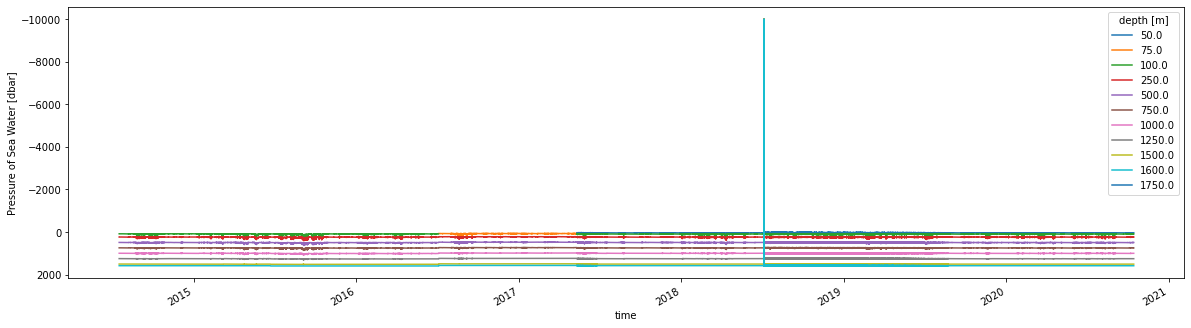

In [7]:
ds_wb1.pres.plot.line(x='time', figsize = (20,5), yincrease = False); #.where(ds.pres>0);
# need to remove the spike

In [8]:
ds_wb1 = ds_wb1.where(ds_wb1.pres>0)

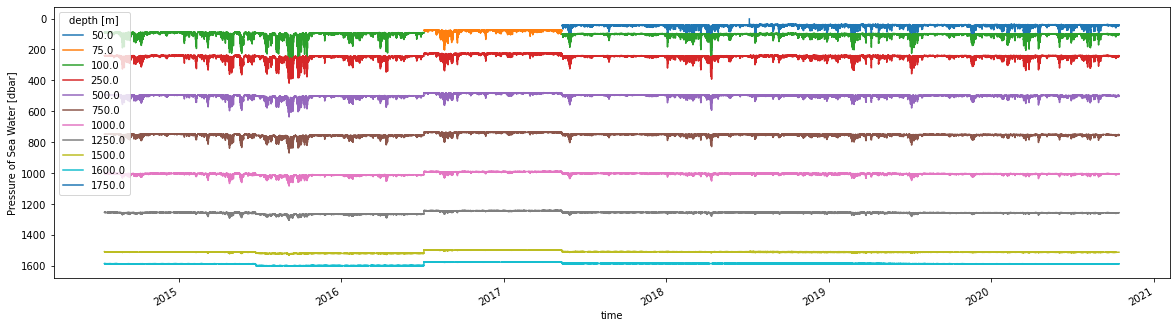

In [9]:
ds_wb1.pres.plot.line(x='time', figsize = (20,5), yincrease = False);

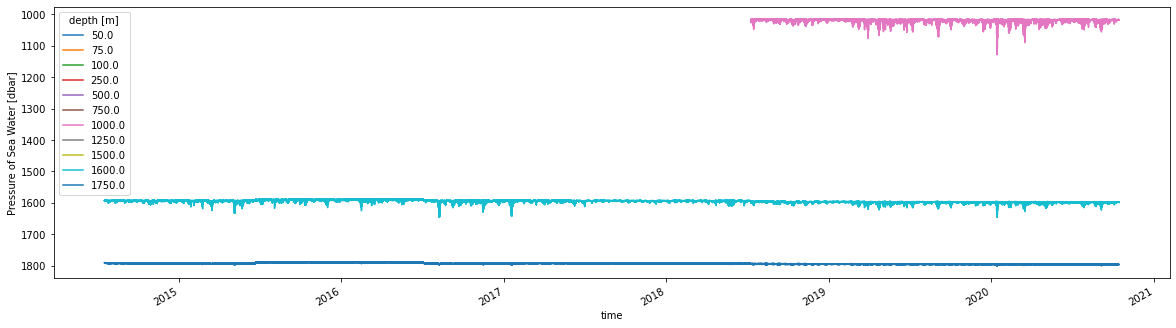

In [10]:
ds_wb2.pres.plot.line(x='time', figsize = (20,5), yincrease = False); #.where(ds.pres>0);
# this looks good

In [11]:
ds_wb1 = ds_wb1.resample(time = "1D").mean(keep_attrs=True);
ds_wb2 = ds_wb2.resample(time = "1D").mean(keep_attrs=True);

In [12]:
ds_wb = xr.concat([ds_wb1, ds_wb2], dim='moor')

In [13]:
ds_wb = ds_wb.mean('moor', keep_attrs=True)

In [14]:
ds_wb

<xarray.Dataset>
Dimensions:  (depth: 11, time: 2282)
Coordinates:
  * time     (time) datetime64[ns] 2014-07-17 2014-07-18 ... 2020-10-14
  * depth    (depth) float64 50.0 75.0 100.0 250.0 ... 1.5e+03 1.6e+03 1.75e+03
Data variables:
    temp     (time, depth) float64 nan nan 10.05 9.724 ... 4.854 4.183 3.357
    pres     (time, depth) float64 nan nan 89.7 ... 1.594e+03 1.796e+03
    sal      (time, depth) float64 nan nan 35.56 35.55 ... 35.23 35.17 35.11
Attributes:
    Mooring:          rtwb1
    WaterDepth:       1600
    Start_Date:       2014/07/17
    Start_Time:       12:30
    End_Date:         2015/06/22
    End_Time:         10:30
    Latitude:         57.470666666666666
    Longitude:        -12.705
    Latitude_units:   degrees_north
    Longitude_units:  degrees_east

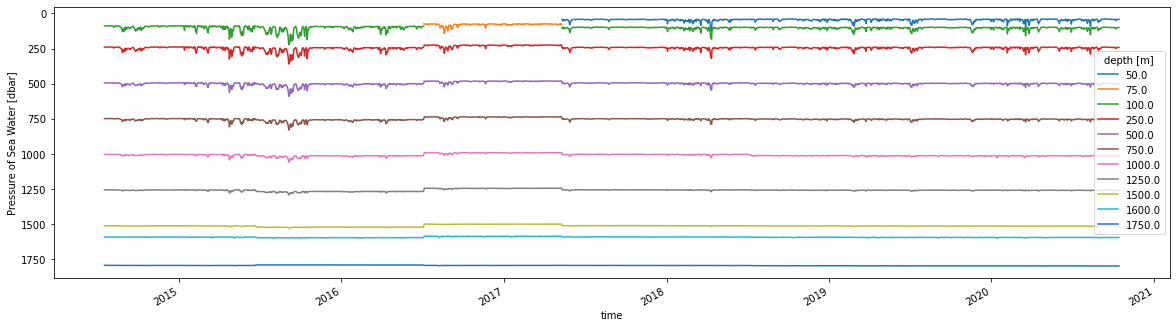

In [15]:
ds_wb.pres.plot.line(x='time', figsize = (20,5), yincrease = False);

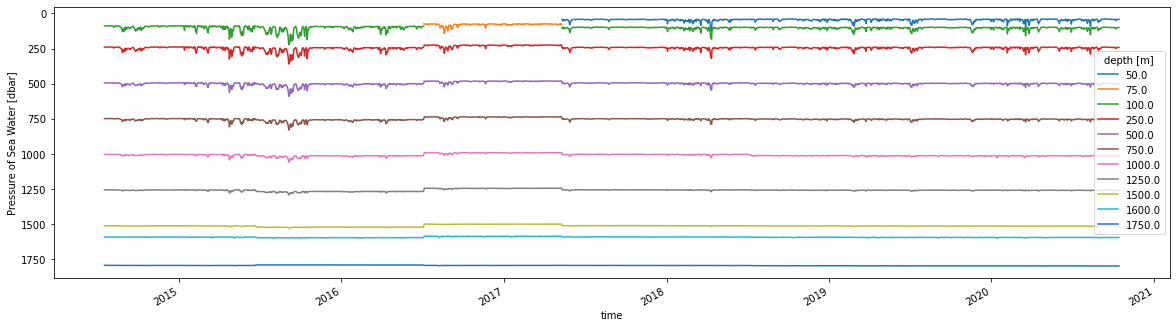

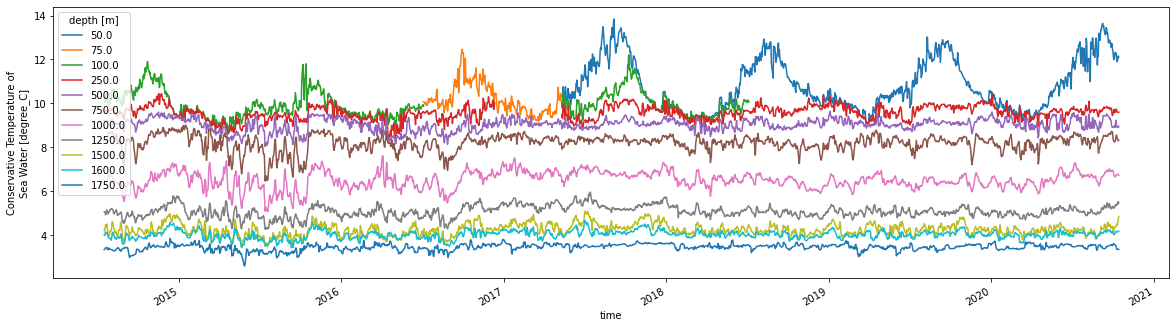

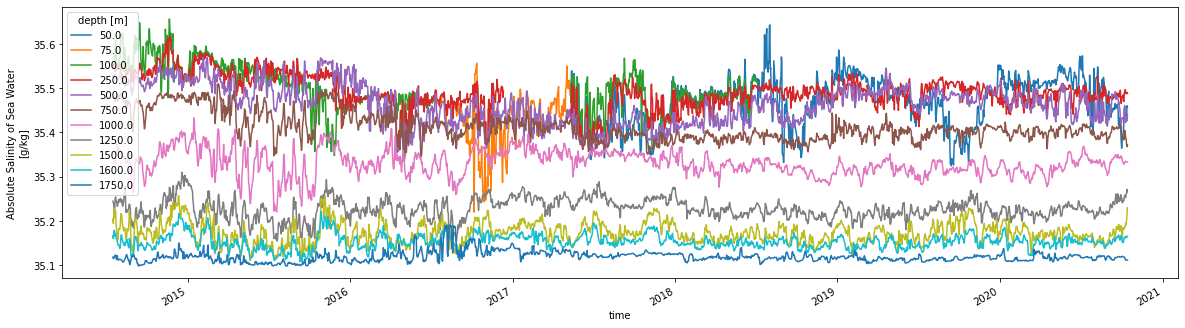

In [16]:
ds_wb.pres.plot.line(x='time', figsize = (20,5), yincrease = False);
ds_wb.temp.plot.line(x='time', figsize = (20,5));
ds_wb.sal.plot.line(x='time', figsize = (20,5));

In [18]:
#ds_wb.to_netcdf('data/rtwb_1D.nc', 
#        engine='netcdf4',
#        encoding={'time':{'units':'days since 1900-01-01 00:00:00'}})